In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cd /gdrive/My Drive/polimi/artificialneuraldeep/Exercise_4/

/gdrive/My Drive/polimi/artificialneuraldeep/Exercise_4


### Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


### Set seed for reproducibility

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# UC Merced Land Use Dataset

http://weegee.vision.ucmerced.edu/datasets/landuse.html

Aerial RGB images of 256x256 pixels. Images belongs to 21 different classes representing the land uses.

Class labels:
0. agricultural
1. airplane
2. baseballdiamond
3. beach
4 .buildings
5. chaparral
6. denseresidential
7. forest
8. freeway
9. golfcourse
10. harbor
11. intersection
12. mediumresidential
13. mobilehomepark
14. overpass
15. parkinglot
16. river
17. runway
18. sparseresidential
19. storagetanks
20. tenniscourt

In [ ]:
# Load the dataset to be used for classification
!unzip UCMerced_LandUse.zip

Archive:  UCMerced_LandUse.zip
   creating: UCMerced_LandUse/
   creating: UCMerced_LandUse/test/
   creating: UCMerced_LandUse/test/agricultural/
  inflating: UCMerced_LandUse/test/agricultural/agricultural01.tif  
  inflating: UCMerced_LandUse/test/agricultural/agricultural08.tif  
  inflating: UCMerced_LandUse/test/agricultural/agricultural20.tif  
  inflating: UCMerced_LandUse/test/agricultural/agricultural26.tif  
  inflating: UCMerced_LandUse/test/agricultural/agricultural30.tif  
  inflating: UCMerced_LandUse/test/agricultural/agricultural33.tif  
  inflating: UCMerced_LandUse/test/agricultural/agricultural37.tif  
  inflating: UCMerced_LandUse/test/agricultural/agricultural40.tif  
  inflating: UCMerced_LandUse/test/agricultural/agricultural41.tif  
  inflating: UCMerced_LandUse/test/agricultural/agricultural72.tif  
  inflating: UCMerced_LandUse/test/agricultural/agricultural79.tif  
  inflating: UCMerced_LandUse/test/agricultural/agricultural82.tif  
  inflating: UCMerced_Lan

In [ ]:
# Dataset folders 
dataset_dir = 'UCMerced_LandUse'
training_dir = os.path.join(dataset_dir, 'training')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')

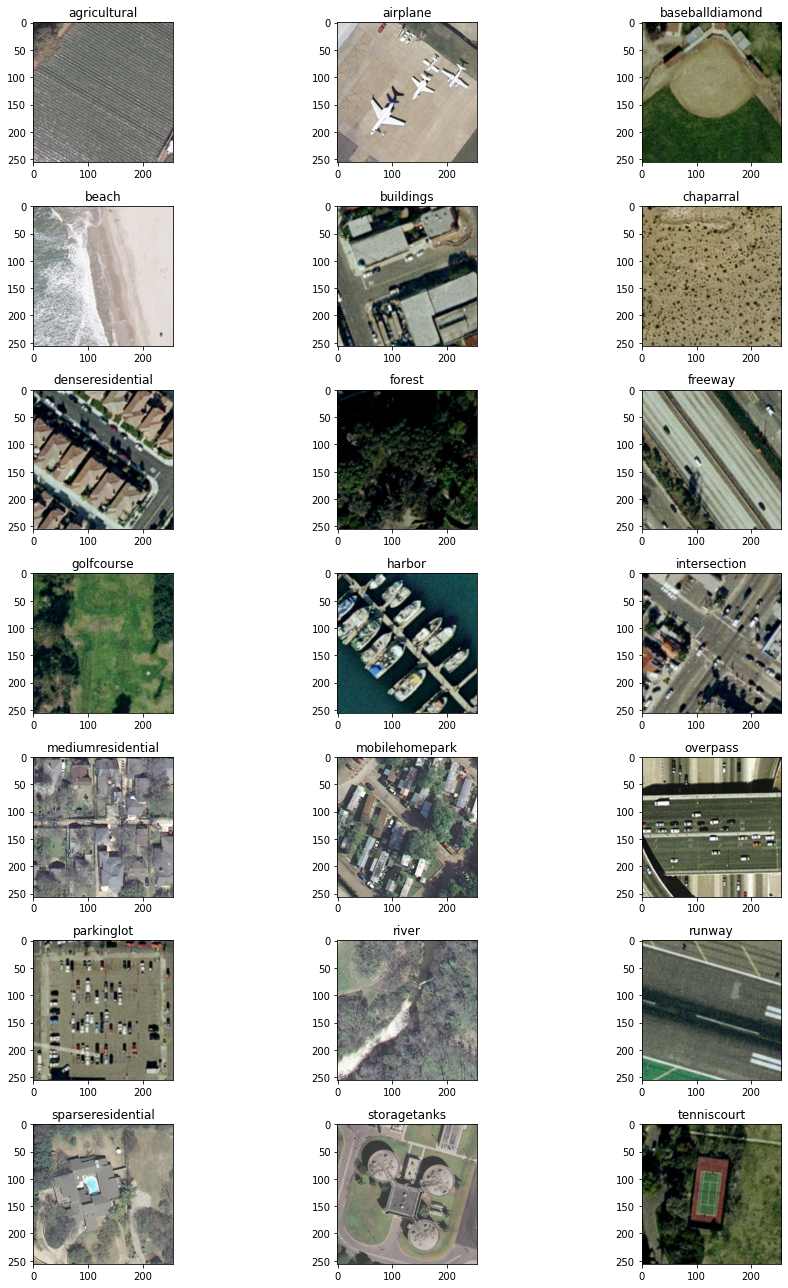

In [ ]:
# Plot example images from dataset
labels = ['agricultural',       # 0
          'airplane',           # 1
          'baseballdiamond',    # 2
          'beach',              # 3
          'buildings',          # 4
          'chaparral',          # 5
          'denseresidential',   # 6
          'forest',             # 7
          'freeway',            # 8
          'golfcourse',         # 9
          'harbor',             # 10
          'intersection',       # 11
          'mediumresidential',  # 12
          'mobilehomepark',     # 13
          'overpass',           # 14
          'parkinglot',         # 15
          'river',              # 16
          'runway',             # 17
          'sparseresidential',  # 18
          'storagetanks',       # 19
          'tenniscourt']        # 20

num_row = 7
num_col = 3
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,6*num_col))
for i in range(num_row*num_col):
  if i < 21:
    class_imgs = next(os.walk('{}/training/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/training/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

# Data Loader

### Typically, data is too large to be loaded as a NumPy array.
### We need a different strategy..

In [ ]:
# Inspect dataset structure on disk
print("Depth 0 (UCMerced_LandUse")
print("-------")
!ls UCMerced_LandUse
print()
print("Depth 1 (e.g., UCMerced_LandUse/training)")
print("------------------------")
!ls UCMerced_LandUse/training
print()
print("Depth 2 (e.g., UCMerced_LandUse/training/agricultural)")
print("----------------------------")
!ls UCMerced_LandUse/training/agricultural


Depth 0 (UCMerced_LandUse
-------
test  training	validation

Depth 1 (e.g., UCMerced_LandUse/training)
------------------------
agricultural	 denseresidential  mediumresidential  sparseresidential
airplane	 forest		   mobilehomepark     storagetanks
baseballdiamond  freeway	   overpass	      tenniscourt
beach		 golfcourse	   parkinglot
buildings	 harbor		   river
chaparral	 intersection	   runway

Depth 2 (e.g., UCMerced_LandUse/training/agricultural)
----------------------------
agricultural00.tif  agricultural27.tif	agricultural53.tif  agricultural75.tif
agricultural02.tif  agricultural28.tif	agricultural54.tif  agricultural76.tif
agricultural03.tif  agricultural29.tif	agricultural55.tif  agricultural77.tif
agricultural04.tif  agricultural31.tif	agricultural56.tif  agricultural78.tif
agricultural05.tif  agricultural32.tif	agricultural58.tif  agricultural81.tif
agricultural07.tif  agricultural34.tif	agricultural59.tif  agricultural83.tif
agricultural09.tif  agricultural35.tif	agricult

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator()
valid_data_gen = ImageDataGenerator()
test_data_gen = ImageDataGenerator()

train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               interpolation='bilinear',
                                               color_mode='rgb',
                                               classes=None, 
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(256, 256),
                                               interpolation='bilinear',
                                               color_mode='rgb',
                                               classes=None, 
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                               target_size=(256, 256),
                                               interpolation='bilinear',
                                               color_mode='rgb',
                                               classes=None, 
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)

Found 1470 images belonging to 21 classes.
Found 315 images belonging to 21 classes.
Found 315 images belonging to 21 classes.


In [ ]:
print("Assigned labels")
print(train_gen.class_indices)
print("Target classes")
print(train_gen.classes)

Assigned labels
{'agricultural': 0, 'airplane': 1, 'baseballdiamond': 2, 'beach': 3, 'buildings': 4, 'chaparral': 5, 'denseresidential': 6, 'forest': 7, 'freeway': 8, 'golfcourse': 9, 'harbor': 10, 'intersection': 11, 'mediumresidential': 12, 'mobilehomepark': 13, 'overpass': 14, 'parkinglot': 15, 'river': 16, 'runway': 17, 'sparseresidential': 18, 'storagetanks': 19, 'tenniscourt': 20}
Target classes
[ 0  0  0 ... 20 20 20]


In [ ]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (8, 256, 256, 3)
Target shape: (8, 21)

Categorical label: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Label: 8
Class name: freeway


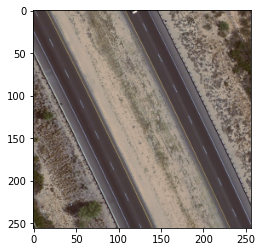

In [ ]:
# Get a sample from dataset and show info
_ = get_next_batch(train_gen)

# Data Augmentation

##### ImageDataGenerator allows to perform data augmentation

```
tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False, samplewise_center=False,
    featurewise_std_normalization=False, samplewise_std_normalization=False,
    zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0,
    height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0,
    channel_shift_range=0.0, fill_mode='nearest', cval=0.0,
    horizontal_flip=False, vertical_flip=False, rescale=None,
    preprocessing_function=None, data_format=None, validation_split=0.0, dtype=None
)
```

Rotation: {'theta': -7.527592869158251, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Shift: {'theta': 0, 'tx': 0, 'ty': 38, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Zoom: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 0.9247240713084175, 'zy': 1.2704285838459497, 'flip_horizontal': 0, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 

Flip: {'theta': 0, 'tx': 0, 'ty': 0, 'shear': 0, 'zx': 1, 'zy': 1, 'flip_horizontal': 1, 'flip_vertical': 0, 'channel_shift_intensity': None, 'brightness': None} 



Text(0.5, 1.0, 'Flipped')

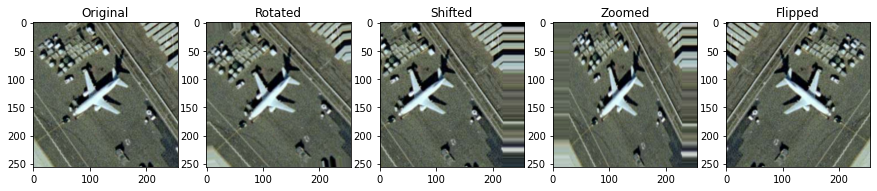

In [ ]:
# Create some augmentation examples

# Get sample image
image = next(train_gen)[0][4]

# Create an instance of ImageDataGenerator for each transformation
rot_gen = ImageDataGenerator(rotation_range=30)
shift_gen = ImageDataGenerator(width_shift_range=50)
zoom_gen = ImageDataGenerator(zoom_range=0.3)
flip_gen = ImageDataGenerator(horizontal_flip=True,)

# Get random transformations
rot_t = rot_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Rotation:', rot_t, '\n')
shift_t = shift_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Shift:', shift_t, '\n')
zoom_t = zoom_gen.get_random_transform(img_shape=(256, 256), seed=seed)
print('Zoom:', zoom_t, '\n')
flip_t = flip_gen.get_random_transform(img_shape=(256, 256), seed=seed) 
print('Flip:', flip_t, '\n')

# Apply the transformation
gen = ImageDataGenerator()
rotated = gen.apply_transform(image, rot_t)
shifted = gen.apply_transform(image, shift_t)
zoomed = gen.apply_transform(image, zoom_t)  
flipped = gen.apply_transform(image, flip_t) 

# Plot original and augmented images
fig, ax = plt.subplots(1, 5, figsize=(15, 45))
ax[0].imshow(np.uint8(image))
ax[0].set_title('Original')
ax[1].imshow(np.uint8(rotated))
ax[1].set_title('Rotated')
ax[2].imshow(np.uint8(shifted))
ax[2].set_title('Shifted')
ax[3].imshow(np.uint8(zoomed))
ax[3].set_title('Zoomed')
ax[4].imshow(np.uint8(flipped))
ax[4].set_title('Flipped')

Transform: {'theta': -7.527592869158251, 'tx': -28, 'ty': 42, 'shear': 0, 'zx': 1.059195090518222, 'zy': 0.7936111842654618, 'flip_horizontal': 1, 'flip_vertical': 1, 'channel_shift_intensity': None, 'brightness': None}


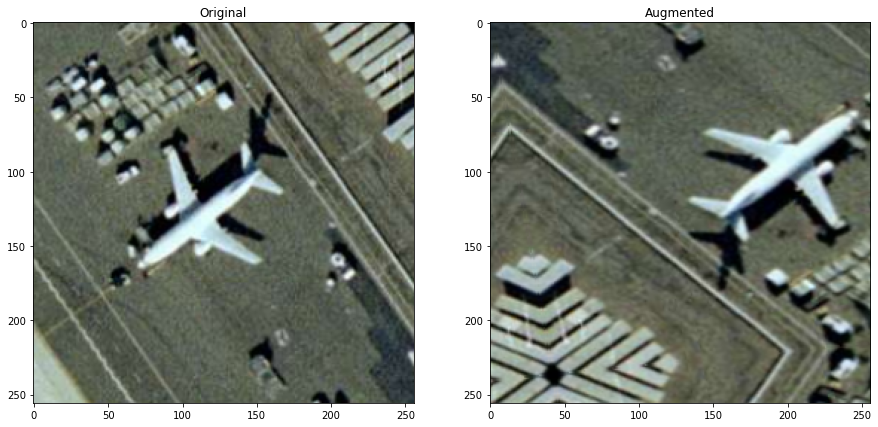

In [ ]:
# Combine multiple transformations
gen = ImageDataGenerator(rotation_range=30,
                         height_shift_range=50,
                         width_shift_range=50,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')

# Get random transformation
t = gen.get_random_transform(img_shape=(256, 256), seed=seed)
print("Transform:", t)

# Apply the transformation
augmented = gen.apply_transform(image, t)

# Plot original and augmented images
fig, ax = plt.subplots(1, 2, figsize=(15,30))
ax[0].imshow(np.uint8(image))
ax[0].set_title("Original")
ax[1].imshow(np.uint8(augmented))
ax[1].set_title("Augmented")
plt.show()

# Training with and without data augmentation

In [ ]:
 #Create an instance of ImageDataGenerator with NO Data Augmentation
noaug_train_data_gen = ImageDataGenerator(rescale=1/255.)
valid_data_gen = ImageDataGenerator(rescale=1/255.)
test_data_gen = ImageDataGenerator(rescale=1/255.) 

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
noaug_train_gen = noaug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               interpolation='bilinear',
                                               color_mode='rgb',
                                               classes=None, 
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)


Found 1470 images belonging to 21 classes.


In [ ]:
# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(rotation_range=30,
                         height_shift_range=50,
                         width_shift_range=50,
                         zoom_range=0.3,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect',
                         rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                               target_size=(256, 256),
                                               interpolation='bilinear',
                                               color_mode='rgb',
                                               classes=None, 
                                               batch_size=8,
                                               shuffle=True,
                                               seed=seed)


Found 1470 images belonging to 21 classes.


### Models metadata

In [ ]:
input_shape = (256, 256, 3)
epochs = 200

### CNN model

In [ ]:
# Model used for the exercise:
# (Conv + ReLU + MaxPool) x 5 + FC x 2
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(input_layer)
    pool1 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool1)
    pool2 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool2)
    pool3 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv3)

    conv4 = tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool3)
    pool4 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv4)

    conv5 = tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides = (1, 1),
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    )(pool4)
    pool5 = tfkl.MaxPooling2D(
        pool_size = (2, 2)
    )(conv5)

    flattening_layer = tfkl.Flatten(name='Flatten')(pool5)
    flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
    classifier_layer = tfkl.Dense(units=512, name='Classifier', kernel_initializer=tfk.initializers.GlorotUniform(seed), activation='relu')(flattening_layer)
    classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=21, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir),'cp'),
                                                      save_weights_only=false,
                                                      save_best_only=False)
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  tb_callback =
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

IndentationError: ignored

In [ ]:
# Build model (for NO augmentation training)
model = build_model(input_shape)
model.summary()

In [ ]:
# Create folders and callbacks and fit
noaug_callbacks = create_folders_and_callbacks(model_name='CNN_NoAug')

# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history

In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_NoAug_Best")

In [ ]:
# Build model (for data augmentation training)
model = build_model(input_shape)

In [ ]:
tf.get_logger().setLevel('WARNING') #  if you want to suppress only INFOs
# tf.get_logger().setLevel('ERROR') #  if you want to suppress both WARNINGs and INFOs

# Create folders and callbacks and fit
aug_callbacks = create_folders_and_callbacks(model_name='CNN_Aug')

# Train the model
history = model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = aug_callbacks,
).history

In [ ]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_Aug_Best")

In [ ]:
# Evaluate on test
# Trainined with no data augmentation
model_noaug = tfk.models.load_model("data_augmentation_experiments/CNN_NoAug_Best")
model_noaug_test_metrics = model_noaug.evaluate(test_gen, return_dict=True)
# Trained with data augmentation
model_aug = tfk.models.load_model("data_augmentation_experiments/CNN_Aug_Best")
model_aug_test_metrics = model_aug.evaluate(test_gen, return_dict=True)

print()
print("Test metrics without data augmentation")
print(model_noaug_test_metrics)
print("Test metrics with data augmentation")
print(model_aug_test_metrics)

# Visualize the activations

In [ ]:
# Get sample batch
batch = next(test_gen)[0]

# Get first image
image = batch[0] # batch size = 8

fig = plt.figure(figsize=(6, 4))
plt.imshow(np.uint8(image*255))

In [ ]:
# Get the activations (the output of each ReLU layer)
# We can do it by creating a new Model (activation_model) with the same input as 
# the original model and all the ReLU activations as output

# Finally we get the output feature maps (for each layer) given the imput test image
fmaps = activation_model.predict(tf.expand_dims(image, 0))

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
%matplotlib inline
def display_activation(fmaps, depth=0, first_n=-1): 
    # fmaps: list of all the feature maps for each layer
    # depth: the layer we want to visualize (an int in [0, network depth))
    # first_n: default '-1' means 'all activations'. Number of activations to be visualized. Note that for deep layers it could be a large number.

    fmaps = fmaps[depth] # get feature maps at the desired depth
    if first_n > 0:
      fmaps = fmaps[0, :, :, :first_n] 
    fmaps = tf.image.resize(fmaps, size=[128, 128]) # resize for visualization

    # Distribute on a grid for plotting
    col_size = 8
    row_size = fmaps.shape[-1] // 8
    fmap_channel=0
    fig = plt.figure(figsize=(30, 30))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(row_size, col_size),  
                    axes_pad=0.1,  # pad between axes in inch.
                    )
    for row in range(0,row_size):
        for col in range(0,col_size):
            grid[fmap_channel].imshow(fmaps[0, :, :, fmap_channel], cmap='gray', aspect='auto')
            fmap_channel += 1
    plt.show()

In [ ]:
display_activation(fmaps=fmaps, depth=1, first_n=-1)